<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-20.1" data-toc-modified-id="Figure-20.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 20.1</a></span></li><li><span><a href="#Figure-20.2" data-toc-modified-id="Figure-20.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 20.2</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 20
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))
    
#chan2useidx = chan_labels.index('Pz')

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 20.1

In [4]:
chan2plot = 'O1'

# wavelet parameters
min_freq = 2
max_freq = 30
num_frex = 20

# baseline time window
baseline_time = [-.4, -.1]

# other wavelet parameters
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
time = np.arange(-1, 1+1/srate, 1/srate)
half_of_wavelet_size = len(time)//2

# FFT parameters
n_wavelet = len(time)
n_data = pnts*trials
n_convolution = [n_wavelet + n_data -1] * 2 + [n_wavelet+pnts-1]  # ERP is only one trial-length

# find sensor index
sensoridx = chan_labels.index(chan2plot)

# compute ERP
erp = data[:,sensoridx,:].mean(0)

# compute induced power by subtracting ERP from each trial
induced_EEG =  data[:,sensoridx,:] - erp

# FFT of data
fft_EEG = [np.fft.fft(np.reshape(data[:,sensoridx,:],[pnts*trials]), n_convolution[0]),  # total
           np.fft.fft(np.reshape(induced_EEG, [pnts*trials]), n_convolution[1]),  # induced
           np.fft.fft(erp, n_convolution[2])]  # evoked; n.b. doesnt matter that fft longer than time series

# % convert baseline from ms to indices
baseidx = [np.abs(times - baseline_time[0]).argmin(), np.abs(times - baseline_time[1]).argmin()]

# % initialize output time-frequency data
tf = np.zeros((4, len(frequencies), pnts))



for fi in range(len(frequencies)):

    # create wavelet
    wavelet = (np.exp(2*1j*np.pi*frequencies[fi] * time) * np.exp(-time**2/(2*(4/(2*np.pi*frequencies[fi]))**2)))/frequencies[fi]
    
    # run convolution for each of trial, induced, and evoked
    for i in range(3):

        # take FFTG of data
        fft_wavelet = np.fft.fft(wavelet, n_convolution[i])

        # convolution...
        convolution_result_fft = np.fft.ifft(fft_wavelet*fft_EEG[i], n_convolution[i])
        convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
        
        # reshaping and trial averaging is done only on all trials

        if i<2:
            convolution_result_fft = np.reshape(convolution_result_fft, [pnts, trials], order='F')
            
            # compute power
            tf[i, fi] = np.mean(np.abs(convolution_result_fft)**2,1)
        else:
            # with only one trial length, just compute with no averaging
            tf[i, fi] = np.abs(convolution_result_fft)**2

        # db correct power
        tf[i, fi] = 10*np.log10(tf[i, fi] / (tf[i, fi, baseidx[0]:baseidx[1]]).mean())

        # inter-trial phase consistency on total EEG
        if i == 0:
            tf[3, fi] = np.abs(np.mean(np.exp(1j*np.angle(convolution_result_fft)), 1))

analysis_labels = ['A) Total power', 'B) Non-phase-locked power', 'C) Erp power', 'D) ITPC']

# color limits
clims = [[-3, 3], [-3, 3], [-12, 12], [0, .6]]

# scale ERP for plotting
erpt = (erp - erp.min()) / np.max(erp - np.min(erp))
erpt = erpt * (frequencies[-1] - frequencies[0]) + frequencies[0]

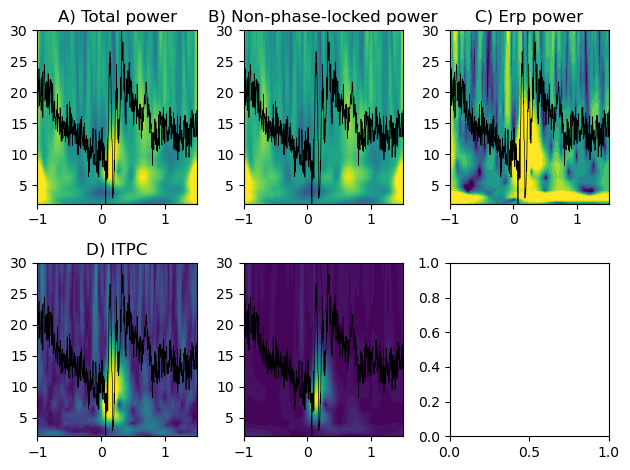

In [5]:
fig, ax = plt.subplots(2,3)

for i in range(4):
    idx = np.unravel_index(i, (2,3))
    ax[idx].contourf(times, frequencies, tf[i], 40, vmin=clims[i][0], vmax=clims[i][1])
    ax[idx].set(title=analysis_labels[i])
    ax[idx].plot(times, erpt, 'k', linewidth=.5)

ax[1,1].contourf(times, frequencies, tf[0]-tf[1], 40)

# plot ERP on top
ax[1,1].plot(times, erpt, 'k', linewidth=.5)

fig.tight_layout()

## Figure 20.2

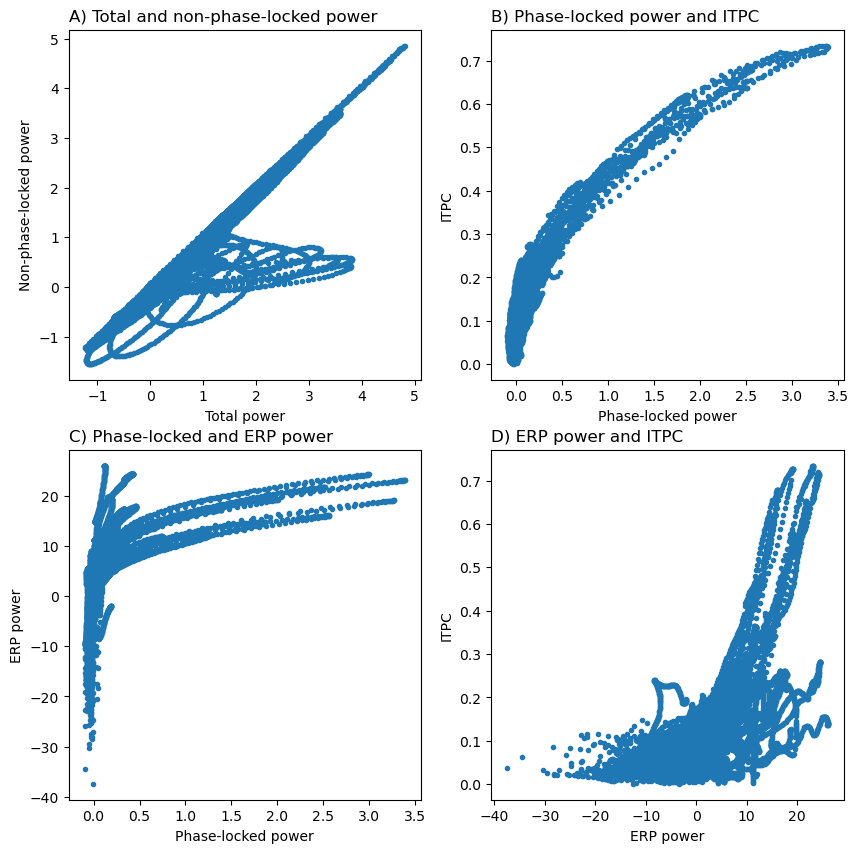

In [6]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,4)
plt.plot(tf[2].flatten(order='f'), tf[3].flatten(order='f'), '.')
plt.setp(plt.gca(), 'xlabel','ERP power', 'ylabel','ITPC')
plt.title('D) ERP power and ITPC', loc='left')

plt.subplot(2,2,2)
plt.plot((tf[0] - tf[1]).flatten('f'), tf[3].flatten(order='f'), '.')
plt.setp(plt.gca(), 'xlabel','Phase-locked power', 'ylabel','ITPC')
plt.title('B) Phase-locked power and ITPC', loc='left')

plt.subplot(2,2,1)
plt.plot(tf[0].flatten(order='f'), tf[1].flatten(order='f'), '.')
plt.setp(plt.gca(), 'xlabel', 'Total power', 'ylabel', 'Non-phase-locked power')
plt.title('A) Total and non-phase-locked power', loc='left')

plt.subplot(2,2,3)
plt.plot((tf[0]-tf[1]).flatten(order='f'), tf[2].flatten(order='f'), '.')
plt.setp(plt.gca(), 'xlabel','Phase-locked power', 'ylabel','ERP power')
plt.title('C) Phase-locked and ERP power', loc='left')

fig.tight_layout()